# Examples

This Jupyter notebook shows some examples for the different functions of the Julia module `zaf`.

Functions:
- [`stft`](#stft) - Compute the short-time Fourier transform (STFT).
- [`istft`](#istft) - Compute the inverse STFT.
- [`cqtkernel`](#cqtkernel) - Compute the constant-Q transform (CQT) kernel.
- [`cqtspectrogram`](#cqtspectrogram) - Compute the CQT spectrogram using a CQT kernel.
- [`cqtchromagram`](#cqtchromagram) - Compute the CQT chromagram using a CQT kernel.
- [`mfcc`](#mfcc) - Compute the mel frequency cepstrum coefficients (MFCCs).
- [`dct`](#dct) - Compute the discrete cosine transform (DCT) using the fast Fourier transform (FFT).
- [`dst`](#dst) - Compute the discrete sine transform (DST) using the FFT.
- [`mdct`](#mdct) - Compute the modified discrete cosine transform (MDCT) using the FFT.
- [`imdct`](#imdct) - Compute the inverse MDCT using the FFT.

Other:
- `hamming` - Compute the Hamming window.
- `kaiser` - Compute the Kaiser window.
- `sigplot` - Plot a signal in seconds.
- `specshow` - Display a spectrogram in dB, seconds, and Hz.
- `cqtspecshow` - Display a CQT spectrogram in dB, seconds, and Hz.
- `cqtchromshow` - Display a CQT chromagram in seconds.


Author:
- Zafar Rafii
- zafarrafii@gmail.com
- http://zafarrafii.com
- https://github.com/zafarrafii
- https://www.linkedin.com/in/zafarrafii/
- 11/12/20

## <a id="stft"></a>Short-time Fourier transform (STFT)

```
audio_stft = zaf.stft(audio_signal, window_function, step_length)

Inputs:
    audio_signal: audio signal (number_samples,)
    window_function: window function (window_length,)
    step_length: step length in samples
Output:
    audio_stft: audio STFT (window_length, number_frames)
```

### Example: compute and display the spectrogram from an audio file

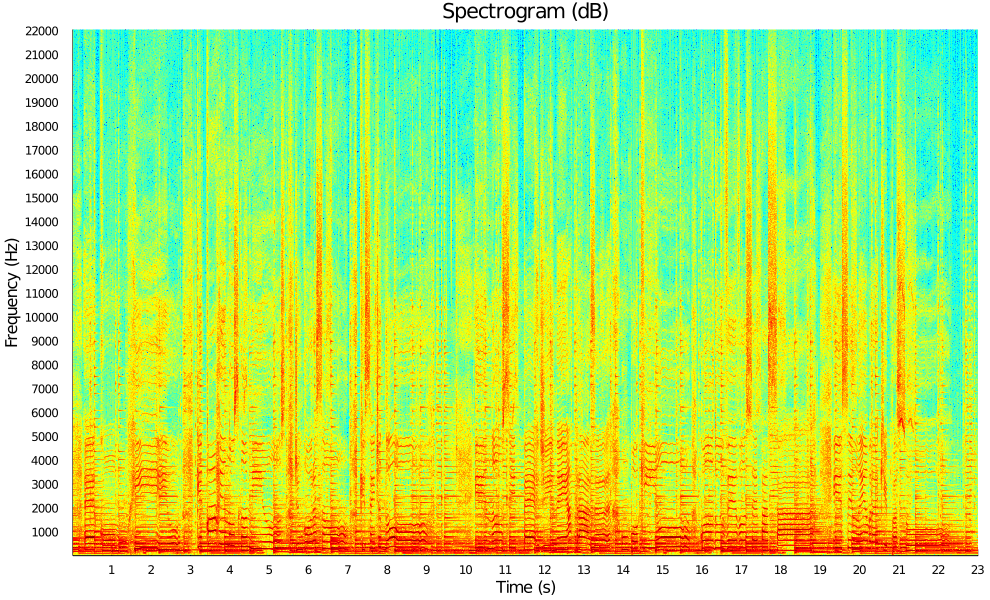

In [42]:
# Load the modules
include("./zaf.jl")
using .zaf
using WAV
using Statistics
using Plots

# Read the audio signal (normalized) with its sampling frequency in Hz, and average it over its channels
audio_signal, sampling_frequency = wavread("audio_file.wav");
audio_signal = mean(audio_signal, dims=2);

# Set the window duration in seconds (audio is stationary around 40 milliseconds)
window_duration = 0.04;

# Derive the window length in samples (use powers of 2 for faster FFT and constant overlap-add (COLA))
window_length = nextpow(2, ceil(Int, window_duration*sampling_frequency));

# Compute the window function (periodic Hamming window for COLA)
window_function = zaf.hamming(window_length, "periodic");

# Set the step length in samples (half of the window length for COLA)
step_length = convert(Int, window_length/2);

# Compute the STFT
audio_stft = zaf.stft(audio_signal, window_function, step_length)

# Derive the magnitude spectrogram (without the DC component and the mirrored frequencies)
audio_spectrogram = abs.(audio_stft[2:convert(Int, window_length/2)+1, :])

# Magnitude spectrogram (without the DC component and the mirrored frequencies)
audio_spectrogram = abs.(audio_stft[2:convert(Int, window_length/2)+1,:]);

# Display the spectrogram in dB, seconds, and Hz
xtick_step = 1
ytick_step = 1000
plot_object = zaf.specshow(audio_spectrogram, length(audio_signal), sampling_frequency, xtick_step, ytick_step);
heatmap!(title = "Spectrogram (dB)", size = (990, 600))

## <a id="istft"></a>Inverse short-time Fourier transform (STFT)

```
audio_signal = zaf.istft(audio_stft, window_function, step_length)

Inputs:
    audio_stft: audio STFT (window_length, number_frames)
    window_function: window function (window_length,)
    step_length: step length in samples
Output:
    audio_signal: audio signal (number_samples,)
```

### Example: estimate the center and the sides from a stereo audio file

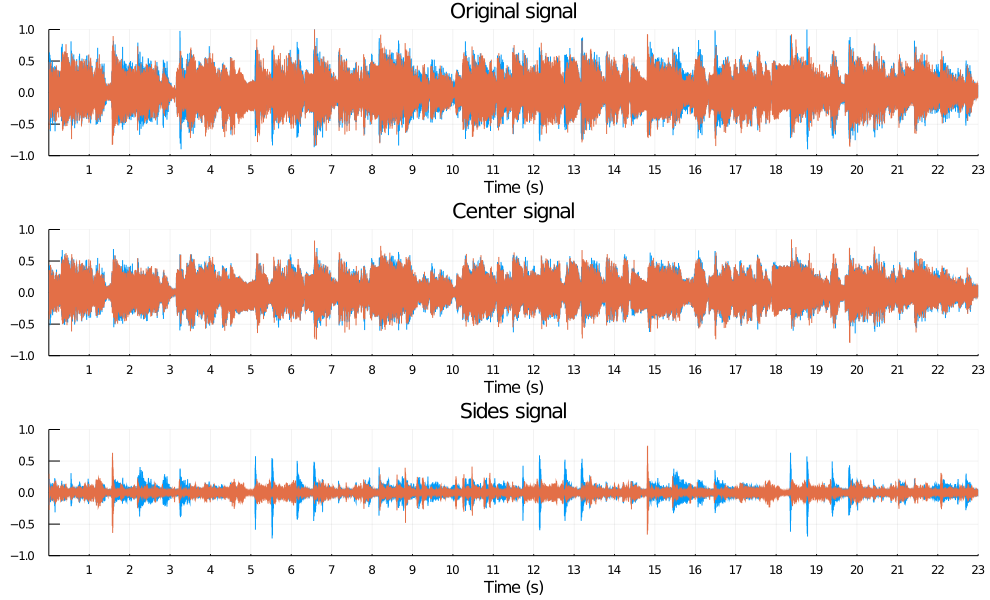

In [44]:
# Load the modules
include("./zaf.jl")
using .zaf
using WAV
using Plots

# Read the (stereo) audio signal with its sampling frequency in Hz
audio_signal, sampling_frequency = wavread("audio_file.wav");

# Set the parameters for the STFT
window_duration = 0.04;
window_length = nextpow(2, ceil(Int, window_duration*sampling_frequency));
window_function = zaf.hamming(window_length, "periodic");
step_length = convert(Int, window_length/2);

# Compute the STFTs for the left and right channels
audio_stft1 = zaf.stft(audio_signal[:,1], window_function, step_length);
audio_stft2 = zaf.stft(audio_signal[:,2], window_function, step_length);

# Derive the magnitude spectrograms (with DC component) for the left and right channels
audio_spectrogram1 = abs.(audio_stft1[1:convert(Int, window_length/2)+1, :]);
audio_spectrogram2 = abs.(audio_stft2[1:convert(Int, window_length/2)+1, :]);

# Estimate the time-frequency masks for the left and right channels for the center
center_mask1 = min.(audio_spectrogram1, audio_spectrogram2)./audio_spectrogram1;
center_mask2 = min.(audio_spectrogram1, audio_spectrogram2)./audio_spectrogram2;

# Derive the STFTs for the left and right channels for the center (with mirrored frequencies)
center_stft1 = [center_mask1; center_mask1[convert(Int, window_length/2):-1:2,:]].*audio_stft1;
center_stft2 = [center_mask2; center_mask2[convert(Int, window_length/2):-1:2,:]].*audio_stft2;

# Synthesize the signals for the left and right channels for the center
center_signal1 = zaf.istft(center_stft1, window_function, step_length);
center_signal2 = zaf.istft(center_stft2, window_function, step_length);

# Derive the final stereo center and sides signals
center_signal = hcat(center_signal1, center_signal2);
center_signal = center_signal[1:size(audio_signal, 1), :];
sides_signal = audio_signal-center_signal;

# Write the center and sides signals
wavwrite(center_signal, "center_signal.wav", Fs=sampling_frequency);
wavwrite(sides_signal, "sides_signal.wav", Fs=sampling_frequency);

# Display the original, center, and sides signals in seconds
xtick_step = 1
plot_object1 = zaf.sigplot(audio_signal, sampling_frequency, xtick_step);
plot!(ylims = (-1, 1), title = "Original signal")
plot_object2 = zaf.sigplot(center_signal, sampling_frequency, xtick_step);
plot!(ylims = (-1, 1), title = "Center signal")
plot_object3 = zaf.sigplot(sides_signal, sampling_frequency, xtick_step);
plot!(ylims = (-1, 1), title = "Sides signal")
plot(plot_object1, plot_object2, plot_object3, layout = (3, 1), size = (990, 600))

## <a id="cqtkernel"></a>Constant-Q transform (CQT) kernel

```
cqt_kernel = zaf.cqtkernel(sampling_frequency, frequency_resolution, minimum_frequency, maximum_frequency)

Inputs:
    sampling_frequency: sampling frequency in Hz
    frequency_resolution: frequency resolution in number of frequency channels per semitone
    minimum_frequency: minimum frequency in Hz
    maximum_frequency: maximum frequency in Hz
Output:
    cqt_kernel: CQT kernel (number_frequencies, fft_length)
```

### Example: compute and display a CQT kernel

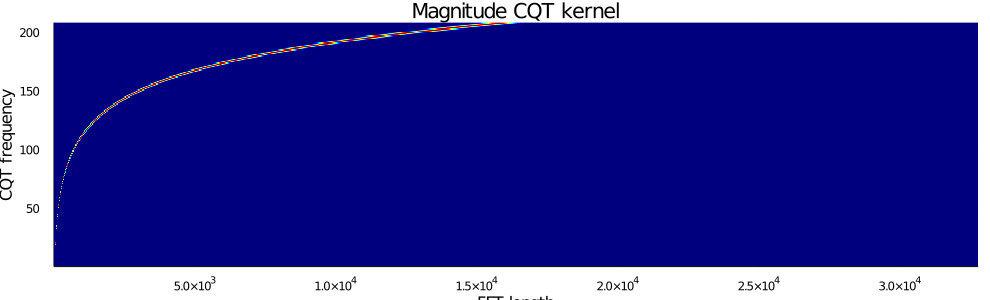

In [48]:
# Load the modules
include("./zaf.jl")
using .zaf
using Plots

# Set the parameters for the CQT kernel
sampling_frequency = 44100;
frequency_resolution = 2;
minimum_frequency = 55;
maximum_frequency = sampling_frequency/2;

# Compute the CQT kernel
cqt_kernel = zaf.cqtkernel(sampling_frequency, frequency_resolution, minimum_frequency, maximum_frequency);

# Display the magnitude CQT kernel
heatmap(abs.(Array(cqt_kernel)), fillcolor = :jet, legend = false, fmt = :png, size = (990, 300), 
    title = "Magnitude CQT kernel", xlabel = "FFT length", ylabel = "CQT frequency")